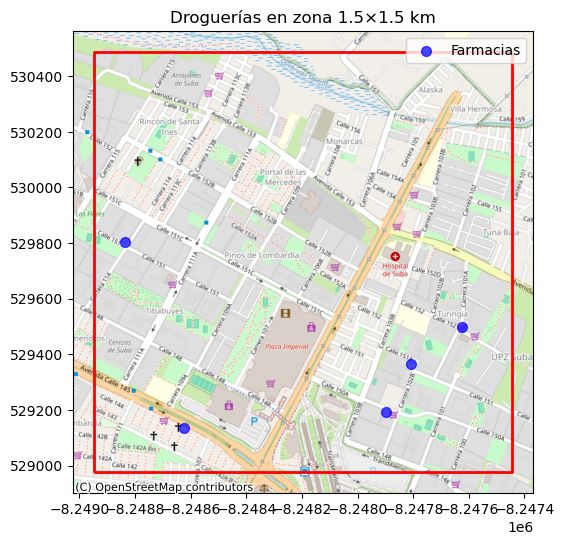

Mapa guardado en mapa_farmacias.png


In [1]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
import requests

def get_pharmacies(center_lat, center_lon, size_km=1):
    # Calcular bounding box
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node["amenity"="pharmacy"]({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    # Extraer coordenadas
    coords = [(el["lon"], el["lat"]) for el in data["elements"] if el["type"] == "node"]

    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [c[0] for c in coords], 
        [c[1] for c in coords]
    ), crs="EPSG:4326")

    return gdf

def plot_area_with_pharmacies(center_lat, center_lon, size_km=1, zoom=16, filename="mapa_farmacias.png"):
    # Bounding box para el área
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg
    bbox = box(lon_min, lat_min, lon_max, lat_max)

    gdf_area = gpd.GeoDataFrame({"geometry": [bbox]}, crs="EPSG:4326")
    gdf_area_web = gdf_area.to_crs(epsg=3857)

    # Obtener farmacias
    gdf_pharm = get_pharmacies(center_lat, center_lon, size_km)
    gdf_pharm_web = gdf_pharm.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf_area_web.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
    if not gdf_pharm_web.empty:
        gdf_pharm_web.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Farmacias")

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    plt.title(f"Droguerías en zona {size_km}×{size_km} km")
    plt.show()

    # Guardar a archivo
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Mapa guardado en {filename}")


# Ejemplo: 1 km alrededor de Bogotá centro
plot_area_with_pharmacies(center_lat=4.7532, center_lon=-74.0948, size_km=1.5)


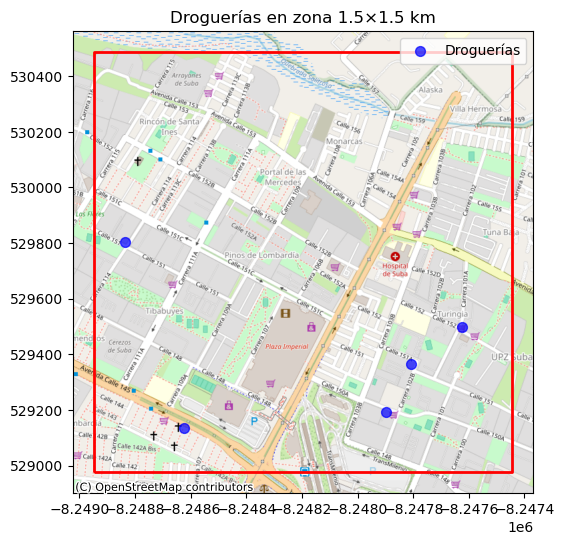

Mapa de Droguerías guardado en droguerias.png


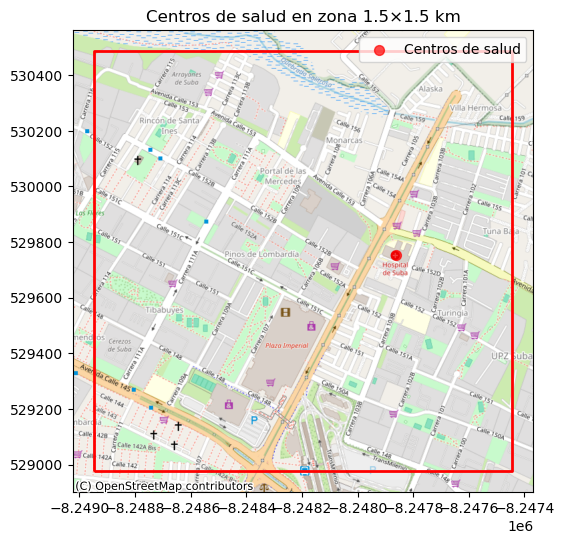

Mapa de Centros de salud guardado en salud.png


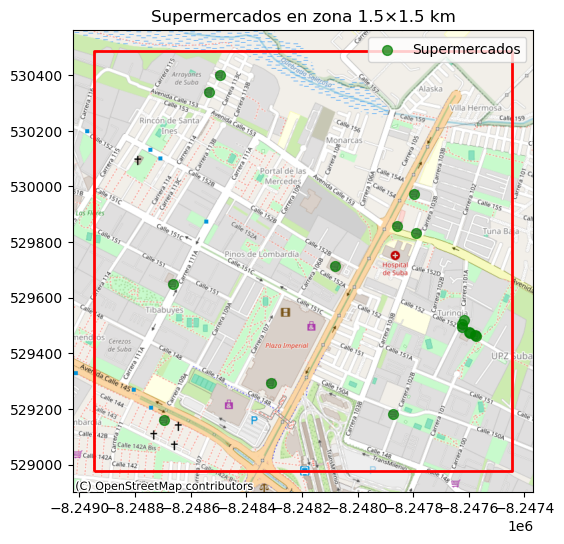

Mapa de Supermercados guardado en supermercados.png


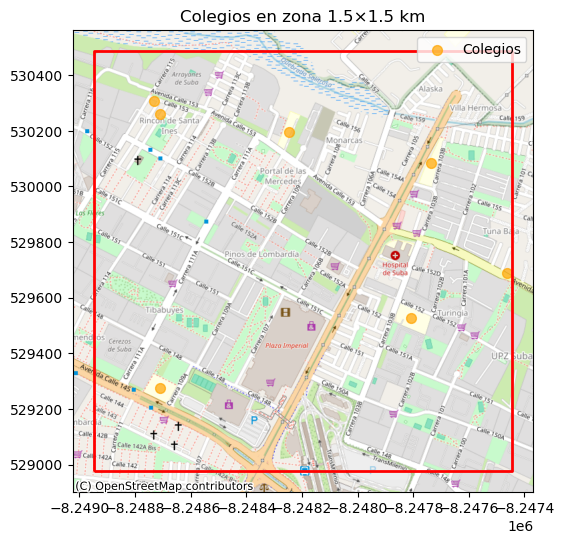

Mapa de Colegios guardado en colegios.png


In [2]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
import requests

def get_pois(center_lat, center_lon, size_km, query_filter):
    # Calcular bounding box
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    # Extraer coordenadas
    coords = []
    for el in data["elements"]:
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            [c[0] for c in coords],
            [c[1] for c in coords]
        ),
        crs="EPSG:4326"
    )

    return gdf

def plot_category(center_lat, center_lon, size_km, zoom, category_name, query_filter, color, filename):
    # Bounding box para el área
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg
    bbox = box(lon_min, lat_min, lon_max, lat_max)

    gdf_area = gpd.GeoDataFrame({"geometry": [bbox]}, crs="EPSG:4326")
    gdf_area_web = gdf_area.to_crs(epsg=3857)

    # Obtener POIs
    gdf_pois = get_pois(center_lat, center_lon, size_km, query_filter)
    gdf_pois_web = gdf_pois.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf_area_web.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
    if not gdf_pois_web.empty:
        gdf_pois_web.plot(ax=ax, color=color, markersize=50, alpha=0.7, label=category_name)

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    plt.title(f"{category_name} en zona {size_km}×{size_km} km")
    plt.show()

    # Guardar
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Mapa de {category_name} guardado en {filename}")


# Coordenadas de ejemplo (Bogotá centro)
lat, lon = 4.7532, -74.0948
size_km = 1.5
zoom = 16

# Droguerías
plot_category(lat, lon, size_km, zoom, "Droguerías", '["amenity"="pharmacy"]', "blue", "droguerias.png")

# Centros de salud
plot_category(lat, lon, size_km, zoom, "Centros de salud", '["amenity"="hospital"]', "red", "salud.png")

# Supermercados
plot_category(lat, lon, size_km, zoom, "Supermercados", '["shop"="supermarket"]', "green", "supermercados.png")

# Colegios
plot_category(lat, lon, size_km, zoom, "Colegios", '["amenity"="school"]', "orange", "colegios.png")


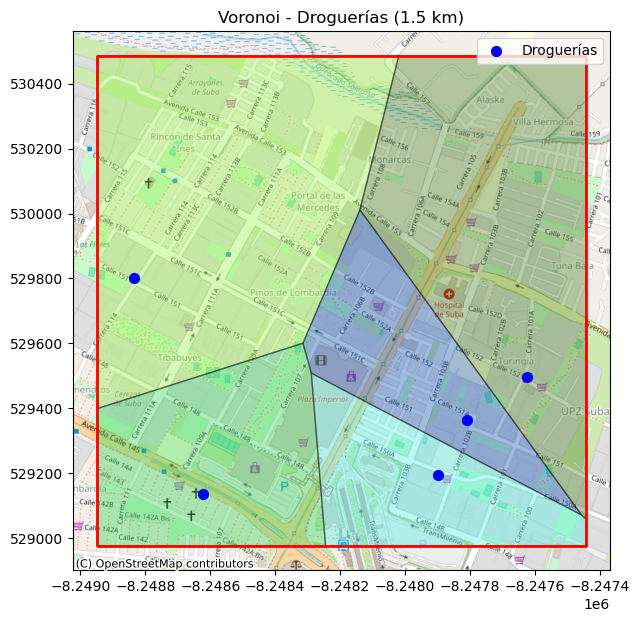

Mapa Voronoi de Droguerías guardado en voronoi_outputs\voronoi_droguerias.png
Exportados GeoJSON/CSV para Droguerías
Aviso: solo 2 puntos en Centros de salud (ampliado) — Voronoi puede ser poco informativo.


QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qbb Qz Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 543616610  voronoi  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0


In [11]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box, Polygon
from scipy.spatial import Voronoi
import numpy as np
import requests
import random
import os

# -------------------------
# Funciones auxiliares
# -------------------------
def get_pois(center_lat, center_lon, size_km, query_filter):
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json][timeout:60];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    try:
        response = requests.get(overpass_url, params={'data': query}, timeout=60)
        response.raise_for_status()
    except Exception as e:
        raise RuntimeError(f"Error llamando Overpass: {e}")

    data = response.json()
    coords = []
    for el in data.get("elements", []):
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    if not coords:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy([c[0] for c in coords], [c[1] for c in coords]),
        crs="EPSG:4326"
    )
    return gdf

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2.0

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if vertices is None:
            continue
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue
            v = v1 if v1 >= 0 else v2
            tangent = vor.points[p2] - vor.points[p1]
            tangent = tangent / np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = vor.vertices[v] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]
        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

def compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             category_name, query_filter, color, filename,
                             zoom=16, save_geojson=False, out_folder="."):
    # bbox en grados
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg; lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg; lon_max = center_lon + delta_deg
    if lon_min > lon_max: lon_min, lon_max = lon_max, lon_min
    if lat_min > lat_max: lat_min, lat_max = lat_max, lat_min

    bbox = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
    gdf_bbox_3857 = gdf_bbox.to_crs(epsg=3857)

    # POIs
    gdf_pois = get_pois(center_lat, center_lon, size_km, query_filter)
    if gdf_pois.empty:
        print(f"No se encontraron {category_name} en el área.")
        return
    gdf_pois_3857 = gdf_pois.to_crs(epsg=3857)

    points = np.array([[pt.x, pt.y] for pt in gdf_pois_3857.geometry])
    if points.shape[0] < 2:
        print(f"No hay suficientes puntos para Voronoi de {category_name} (se requieren al menos 2).")
        return
    if points.shape[0] < 4:
        print(f"Aviso: solo {points.shape[0]} puntos en {category_name} — Voronoi puede ser poco informativo.")

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)

    polygons = []
    for region in regions:
        poly = Polygon(vertices[region])
        if poly.is_valid:
            polygons.append(poly)
    if not polygons:
        print(f"No se pudieron construir polígonos Voronoi para {category_name}.")
        return

    gdf_voronoi = gpd.GeoDataFrame({"geometry":polygons}, crs="EPSG:3857")

    # Clip/recorte al bbox
    try:
        gdf_voronoi_clipped = gpd.overlay(gdf_voronoi, gdf_bbox_3857, how="intersection")
    except Exception:
        # fallback: intersecar manualmente
        bbox_union = gdf_bbox_3857.geometry.unary_union
        gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(bbox_union)
        gdf_voronoi_clipped = gdf_voronoi[gdf_voronoi.geometry.area > 0].copy()

    if gdf_voronoi_clipped.empty:
        print(f"Tras recorte no hay polígonos Voronoi dentro del bounding box para {category_name}.")
        return

    # Plot
    fig, ax = plt.subplots(figsize=(7,7))
    gdf_bbox_3857.boundary.plot(ax=ax, color="red", linewidth=2)
    gdf_voronoi_clipped = gdf_voronoi_clipped.reset_index(drop=True)
    rand_colors = [(random.random(), random.random(), random.random()) for _ in range(len(gdf_voronoi_clipped))]
    gdf_voronoi_clipped.plot(ax=ax, facecolor=rand_colors, edgecolor="black", alpha=0.4)
    gdf_pois_3857.plot(ax=ax, color=color, markersize=50, label=category_name, zorder=5)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    # crear carpeta si no existe
    os.makedirs(out_folder, exist_ok=True)
    out_png = os.path.join(out_folder, filename)
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.title(f"Voronoi - {category_name} ({size_km} km)")
    plt.show()
    print(f"Mapa Voronoi de {category_name} guardado en {out_png}")

    # Export opcional
    if save_geojson:
        gdf_voronoi_clipped.to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_voronoi.geojson"), driver="GeoJSON")
        gdf_pois_3857.to_crs(epsg=4326).to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.geojson"), driver="GeoJSON")
        # CSV de POI
        pois_4326 = gdf_pois_3857.to_crs(epsg=4326)
        pois_4326['lon'] = pois_4326.geometry.x; pois_4326['lat'] = pois_4326.geometry.y
        pois_4326[['lat','lon']].to_csv(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.csv"), index=False)
        print(f"Exportados GeoJSON/CSV para {category_name}")

# -------------------------
# Lista de categorías (edítala si quieres)
# -------------------------
CATEGORIES = [
    ("Droguerías", '["amenity"="pharmacy"]', "blue", "voronoi_droguerias.png"),
    ("Centros de salud (ampliado)", '["amenity"~"hospital|clinic|doctors"]', "red", "voronoi_salud_ampliado.png"),
    ("Supermercados", '["shop"="supermarket"]', "green", "voronoi_supermercados.png"),
    ("Colegios", '["amenity"="school"]', "orange", "voronoi_colegios.png"),
    # otros negocios comunes:
    ("Restaurantes", '["amenity"="restaurant"]', "purple", "voronoi_restaurantes.png"),
    ("Cafés", '["amenity"="cafe"]', "brown", "voronoi_cafes.png"),
    ("Bancos", '["amenity"="bank"]', "gray", "voronoi_bancos.png"),
    ("Gasolineras", '["amenity"="fuel"]', "black", "voronoi_gasolineras.png"),
    ("Panaderías", '["shop"="bakery"]', "pink", "voronoi_panaderias.png"),
    ("Bares", '["amenity"="bar"]', "teal", "voronoi_bares.png"),
]

# -------------------------
# Ejecución: ajusta center y size_km si necesitas
# -------------------------
center_lat, center_lon = 4.7532, -74.0948   # tu centro
size_km = 1.5
zoom = 16
output_folder = "voronoi_outputs"   # carpeta donde se guardan PNG/GeoJSON si activas

for name, qfilter, color, fname in CATEGORIES:
    compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             name, qfilter, color, fname,
                             zoom=zoom, save_geojson=True, out_folder=output_folder)


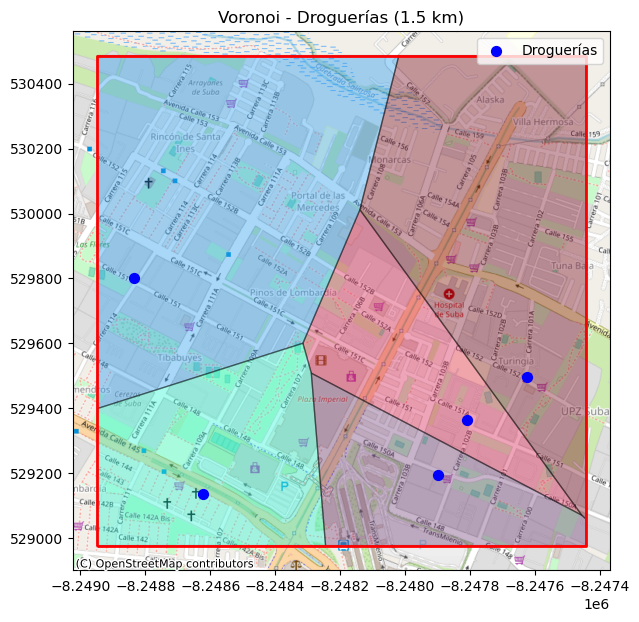

Mapa Voronoi de Droguerías guardado en voronoi_outputs\voronoi_droguerias.png
Exportados GeoJSON/CSV para Droguerías
Aviso: solo 2 puntos en Centros de salud (ampliado) — usando método fallback cuando sea necesario.


TypeError: object of type 'GeometryCollection' has no len()

In [12]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box, Polygon, Point, LineString
from shapely.ops import split
from scipy.spatial import Voronoi
import numpy as np
import requests
import random
import os

# -------------------------
# Funciones auxiliares
# -------------------------
def get_pois(center_lat, center_lon, size_km, query_filter):
    """Consulta Overpass y devuelve GeoDataFrame EPSG:4326 con puntos (lon,lat)."""
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json][timeout:60];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    try:
        response = requests.get(overpass_url, params={'data': query}, timeout=60)
        response.raise_for_status()
    except Exception as e:
        raise RuntimeError(f"Error llamando Overpass: {e}")

    data = response.json()
    coords = []
    for el in data.get("elements", []):
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    if not coords:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy([c[0] for c in coords], [c[1] for c in coords]),
        crs="EPSG:4326"
    )
    return gdf

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruye polígonos finitos para Voronoi 2D (recipe adaptado, compatible con numpy 2.x).
    Devuelve (new_regions, new_vertices).
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)

    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2.0

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if vertices is None:
            continue
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue
            v = v1 if v1 >= 0 else v2
            tangent = vor.points[p2] - vor.points[p1]
            # evitar división por cero
            if np.linalg.norm(tangent) == 0:
                continue
            tangent = tangent / np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = vor.vertices[v] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]
        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

# --- Fallback para pocos puntos: construcción por bisectrices ---
def _make_bisector_line(p1, p2, length):
    """Devuelve LineString perpendicular al segmento p1-p2 centrada en su punto medio y extendida 'length'."""
    p1 = np.asarray(p1); p2 = np.asarray(p2)
    mid = (p1 + p2) / 2.0
    v = p2 - p1
    if np.linalg.norm(v) == 0:
        norm = np.array([1.0, 0.0])
    else:
        norm = np.array([-v[1], v[0]])
        norm = norm / np.linalg.norm(norm)
    a = mid + norm * length
    b = mid - norm * length
    return LineString([tuple(a), tuple(b)])

def _voronoi_fallback_by_splitting(points, bbox_polygon):
    """
    Construye celdas tipo Voronoi dentro de bbox para n=2 o n=3 (o 1).
    points: numpy array (n,2) en la misma proyección (EPSG:3857).
    bbox_polygon: shapely polygon en misma proyección.
    Devuelve GeoDataFrame EPSG:3857.
    """
    n = points.shape[0]
    if n == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")
    if n == 1:
        return gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:3857")

    polys = []
    minx, miny, maxx, maxy = bbox_polygon.bounds
    diag = ((maxx - minx)**2 + (maxy - miny)**2)**0.5
    L = diag * 3.0  # longitud para extender bisectrices

    for i in range(n):
        poly = bbox_polygon
        pi = points[i]
        for j in range(n):
            if i == j:
                continue
            pj = points[j]
            bis_line = _make_bisector_line(pi, pj, L)
            try:
                pieces = split(poly, bis_line)
            except Exception:
                # si split falla por geometría, intentar continuar
                continue
            if len(pieces) == 1:
                continue
            # elegir la pieza que contenga el punto pi
            chosen = None
            for piece in pieces:
                if piece.contains(Point(pi[0], pi[1])):
                    chosen = piece
                    break
            if chosen is None:
                # si ninguno lo contiene exactamente, elegir por máxima intersección con buffer pequeño
                buf = Point(pi[0], pi[1]).buffer(1.0)
                chosen = max(pieces, key=lambda g: g.intersection(buf).area)
            poly = chosen
            if poly.is_empty:
                break
        polys.append(poly if (poly is not None and not poly.is_empty) else None)

    gdf = gpd.GeoDataFrame({"geometry": [p for p in polys if p is not None]}, crs="EPSG:3857")
    gdf = gdf.reset_index(drop=True)
    return gdf

# -------------------------
# Función principal (Voronoi con fallback)
# -------------------------
def compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             category_name, query_filter, color, filename,
                             zoom=16, save_geojson=False, out_folder="."):
    # bbox en grados (misma lógica original)
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg; lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg; lon_max = center_lon + delta_deg
    if lon_min > lon_max: lon_min, lon_max = lon_max, lon_min
    if lat_min > lat_max: lat_min, lat_max = lat_max, lat_min

    bbox = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
    gdf_bbox_3857 = gdf_bbox.to_crs(epsg=3857)

    # obtener bbox union de forma robusta
    try:
        bbox_union = gdf_bbox_3857.geometry.union_all()
    except Exception:
        bbox_union = gdf_bbox_3857.geometry.unary_union

    # POIs
    gdf_pois = get_pois(center_lat, center_lon, size_km, query_filter)
    if gdf_pois.empty:
        print(f"No se encontraron {category_name} en el área.")
        return
    gdf_pois_3857 = gdf_pois.to_crs(epsg=3857)

    points = np.array([[pt.x, pt.y] for pt in gdf_pois_3857.geometry])
    if points.shape[0] < 2:
        print(f"No hay suficientes puntos para Voronoi de {category_name} (se requieren al menos 2).")
        return
    if points.shape[0] < 4:
        print(f"Aviso: solo {points.shape[0]} puntos en {category_name} — usando método fallback cuando sea necesario.")

    # intentamos Voronoi clásico cuando hay suficiente cantidad; si falla, usamos fallback
    gdf_voronoi = None
    if points.shape[0] >= 4:
        try:
            vor = Voronoi(points)
            regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
            polygons = []
            for region in regions:
                poly = Polygon(vertices[region])
                if poly.is_valid:
                    polygons.append(poly)
            if polygons:
                gdf_voronoi = gpd.GeoDataFrame({"geometry":polygons}, crs="EPSG:3857")
        except Exception as e:
            print(f"Warning: Voronoi clásico falló ({e}), usando fallback geométrico.")
            gdf_voronoi = _voronoi_fallback_by_splitting(points, bbox_union)
    else:
        # fallback directo para 2 o 3 puntos
        gdf_voronoi = _voronoi_fallback_by_splitting(points, bbox_union)

    if gdf_voronoi is None or gdf_voronoi.empty:
        print(f"No se pudieron construir polígonos Voronoi para {category_name}.")
        return

    # Recortar al bbox (intersección)
    try:
        gdf_voronoi_clipped = gpd.overlay(gdf_voronoi, gdf_bbox_3857, how="intersection")
    except Exception:
        gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(bbox_union)
        gdf_voronoi_clipped = gdf_voronoi[gdf_voronoi.geometry.area > 0].copy()

    if gdf_voronoi_clipped.empty:
        print(f"Tras recorte no hay polígonos Voronoi dentro del bounding box para {category_name}.")
        return

    # Plot
    fig, ax = plt.subplots(figsize=(7,7))
    gdf_bbox_3857.boundary.plot(ax=ax, color="red", linewidth=2)
    gdf_voronoi_clipped = gdf_voronoi_clipped.reset_index(drop=True)
    rand_colors = [(random.random(), random.random(), random.random()) for _ in range(len(gdf_voronoi_clipped))]
    gdf_voronoi_clipped.plot(ax=ax, facecolor=rand_colors, edgecolor="black", alpha=0.4)
    gdf_pois_3857.plot(ax=ax, color=color, markersize=50, label=category_name, zorder=5)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()

    os.makedirs(out_folder, exist_ok=True)
    out_png = os.path.join(out_folder, filename)
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.title(f"Voronoi - {category_name} ({size_km} km)")
    plt.show()
    print(f"Mapa Voronoi de {category_name} guardado en {out_png}")

    # export opcional
    if save_geojson:
        gdf_voronoi_clipped.to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_voronoi.geojson"), driver="GeoJSON")
        gdf_pois_3857.to_crs(epsg=4326).to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.geojson"), driver="GeoJSON")
        pois_4326 = gdf_pois_3857.to_crs(epsg=4326)
        pois_4326['lon'] = pois_4326.geometry.x; pois_4326['lat'] = pois_4326.geometry.y
        pois_4326[['lat','lon']].to_csv(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.csv"), index=False)
        print(f"Exportados GeoJSON/CSV para {category_name}")

# -------------------------
# Lista de categorías (edítala si quieres)
# -------------------------
CATEGORIES = [
    ("Droguerías", '["amenity"="pharmacy"]', "blue", "voronoi_droguerias.png"),
    ("Centros de salud (ampliado)", '["amenity"~"hospital|clinic|doctors"]', "red", "voronoi_salud_ampliado.png"),
    ("Supermercados", '["shop"="supermarket"]', "green", "voronoi_supermercados.png"),
    ("Colegios", '["amenity"="school"]', "orange", "voronoi_colegios.png"),
    # otros negocios comunes:
    ("Restaurantes", '["amenity"="restaurant"]', "purple", "voronoi_restaurantes.png"),
    ("Cafés", '["amenity"="cafe"]', "brown", "voronoi_cafes.png"),
    ("Bancos", '["amenity"="bank"]', "gray", "voronoi_bancos.png"),
    ("Gasolineras", '["amenity"="fuel"]', "black", "voronoi_gasolineras.png"),
    ("Panaderías", '["shop"="bakery"]', "pink", "voronoi_panaderias.png"),
    ("Bares", '["amenity"="bar"]', "teal", "voronoi_bares.png"),
]

# -------------------------
# Ejecución: ajusta center y size_km si necesitas
# -------------------------
center_lat, center_lon = 4.7532, -74.0948   # tu centro
size_km = 1.5
zoom = 16
output_folder = "voronoi_outputs"

for name, qfilter, color, fname in CATEGORIES:
    compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             name, qfilter, color, fname,
                             zoom=zoom, save_geojson=True, out_folder=output_folder)


In [13]:
from shapely.geometry import Polygon, Point, GeometryCollection, MultiPolygon

def _voronoi_fallback_by_splitting(points, bbox_polygon):
    """
    Construye celdas tipo Voronoi dentro de bbox para n=1,2 o 3 puntos.
    points: numpy array (n,2) en la misma proyección (EPSG:3857).
    bbox_polygon: shapely polygon en misma proyección.
    Devuelve GeoDataFrame EPSG:3857.
    """
    n = points.shape[0]
    if n == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")
    if n == 1:
        return gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:3857")

    polys = []
    minx, miny, maxx, maxy = bbox_polygon.bounds
    diag = ((maxx - minx)**2 + (maxy - miny)**2)**0.5
    L = diag * 3.0  # longitud para extender bisectrices

    for i in range(n):
        poly = bbox_polygon
        pi = points[i]
        for j in range(n):
            if i == j:
                continue
            pj = points[j]
            bis_line = _make_bisector_line(pi, pj, L)
            try:
                pieces = split(poly, bis_line)
            except Exception:
                # si split falla, intentamos continuar con la siguiente bisectriz
                continue

            # Normalizar resultado: convertir a lista de geometrías poligonales
            pieces_list = []
            if pieces is None:
                pieces_list = []
            elif isinstance(pieces, GeometryCollection) or hasattr(pieces, "geoms"):
                # GeometryCollection o Multi* -> iterar geoms
                for g in getattr(pieces, "geoms", [pieces]):
                    # solo polígonos con área significativa
                    if isinstance(g, (Polygon, MultiPolygon)) and (not g.is_empty) and (g.area > 0):
                        pieces_list.append(g)
            else:
                # caso inesperado: si es Polygon único
                if isinstance(pieces, (Polygon, MultiPolygon)) and (not pieces.is_empty) and (pieces.area > 0):
                    pieces_list = [pieces]

            if not pieces_list:
                # no se obtuvo ningún polígono al partir; dejamos poly igual y seguimos
                continue

            # Si hay una sola pieza poligonal, tomarla
            if len(pieces_list) == 1:
                chosen = pieces_list[0]
                poly = chosen
                if poly.is_empty:
                    break
                continue

            # Si hay múltiples piezas, intentar elegir la que contenga el punto
            chosen = None
            p_point = Point(pi[0], pi[1])
            for piece in pieces_list:
                try:
                    if piece.contains(p_point):
                        chosen = piece
                        break
                except Exception:
                    # en casos degenerados skip
                    pass

            if chosen is None:
                # si ninguno lo contiene exactamente (problemas de borde),
                # elegir la pieza con mayor intersección con un buffer pequeño
                buf = p_point.buffer(max(1.0, diag * 0.0001))  # buffer pequeño en metros
                best = max(pieces_list, key=lambda g: g.intersection(buf).area)
                chosen = best

            poly = chosen
            if poly.is_empty:
                break

        # Si resultó vacío tras iterar todas las bisectrices, guardamos None
        if poly is None or poly.is_empty:
            polys.append(None)
        else:
            polys.append(poly)

    # Filtrar nulos y construir GeoDataFrame
    valid_polys = [p for p in polys if (p is not None and (not p.is_empty))]
    if not valid_polys:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")
    gdf = gpd.GeoDataFrame({"geometry": valid_polys}, crs="EPSG:3857")
    gdf = gdf.reset_index(drop=True)
    return gdf


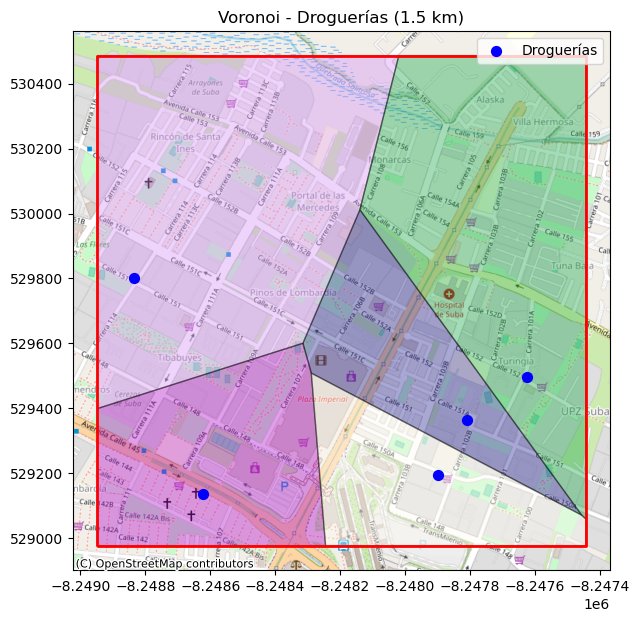

Mapa Voronoi de Droguerías guardado en voronoi_outputs\voronoi_droguerias.png
Exportados GeoJSON/CSV para Droguerías
Aviso: solo 2 puntos en Centros de salud (ampliado) — usando método fallback cuando sea necesario.


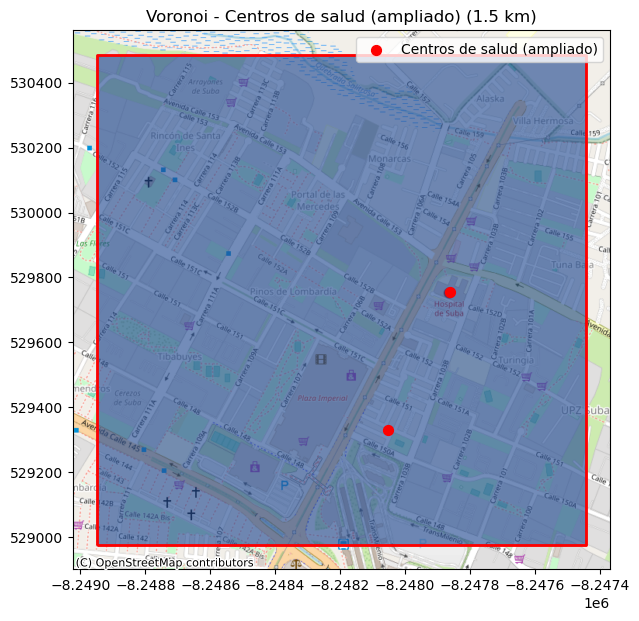

Mapa Voronoi de Centros de salud (ampliado) guardado en voronoi_outputs\voronoi_salud_ampliado.png
Exportados GeoJSON/CSV para Centros de salud (ampliado)


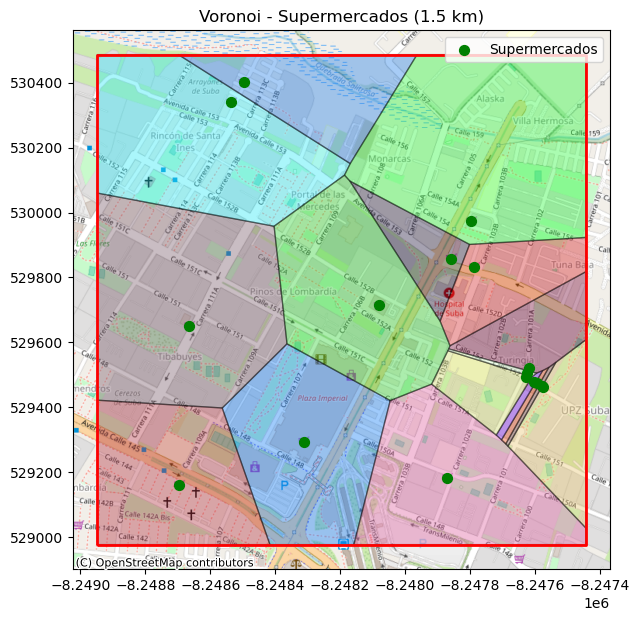

Mapa Voronoi de Supermercados guardado en voronoi_outputs\voronoi_supermercados.png
Exportados GeoJSON/CSV para Supermercados


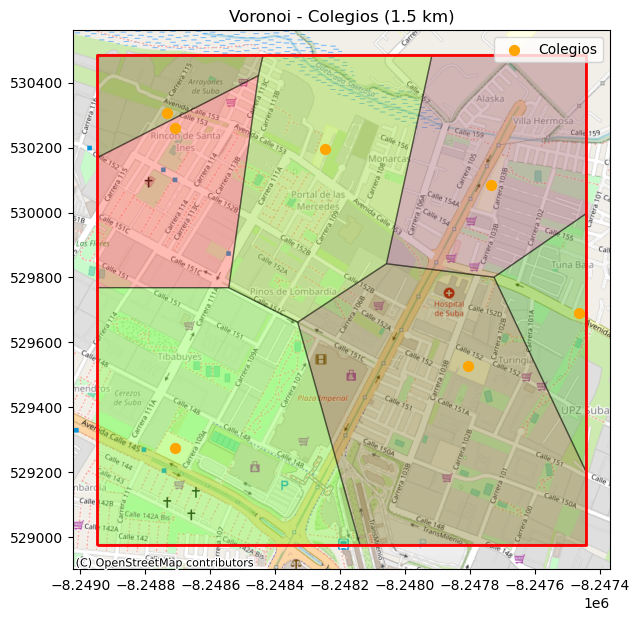

Mapa Voronoi de Colegios guardado en voronoi_outputs\voronoi_colegios.png
Exportados GeoJSON/CSV para Colegios


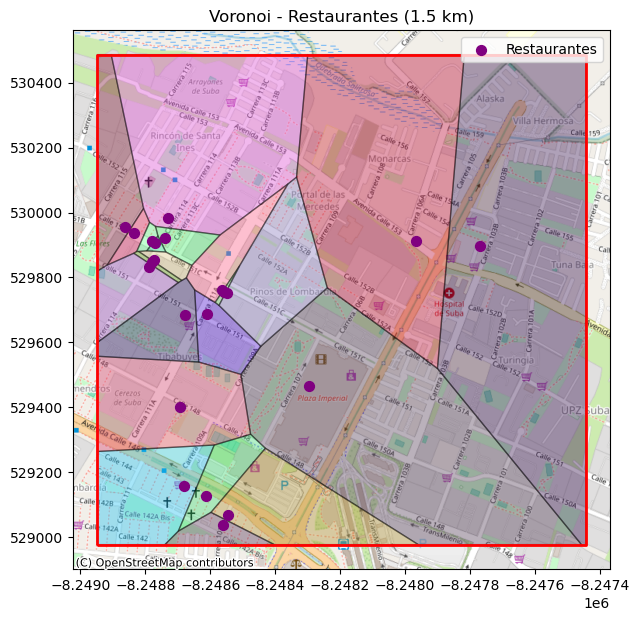

Mapa Voronoi de Restaurantes guardado en voronoi_outputs\voronoi_restaurantes.png
Exportados GeoJSON/CSV para Restaurantes


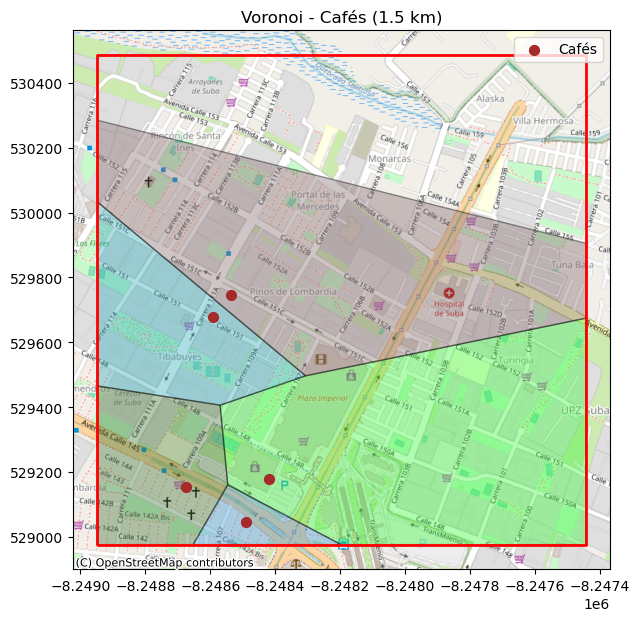

Mapa Voronoi de Cafés guardado en voronoi_outputs\voronoi_cafes.png
Exportados GeoJSON/CSV para Cafés


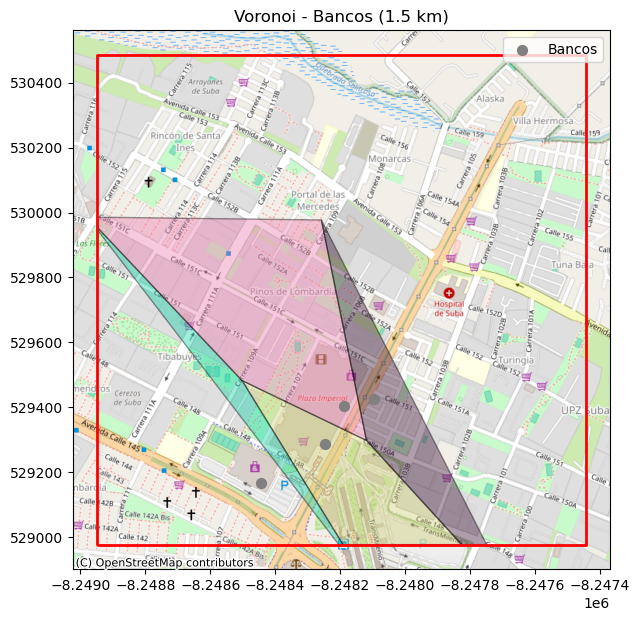

Mapa Voronoi de Bancos guardado en voronoi_outputs\voronoi_bancos.png
Exportados GeoJSON/CSV para Bancos


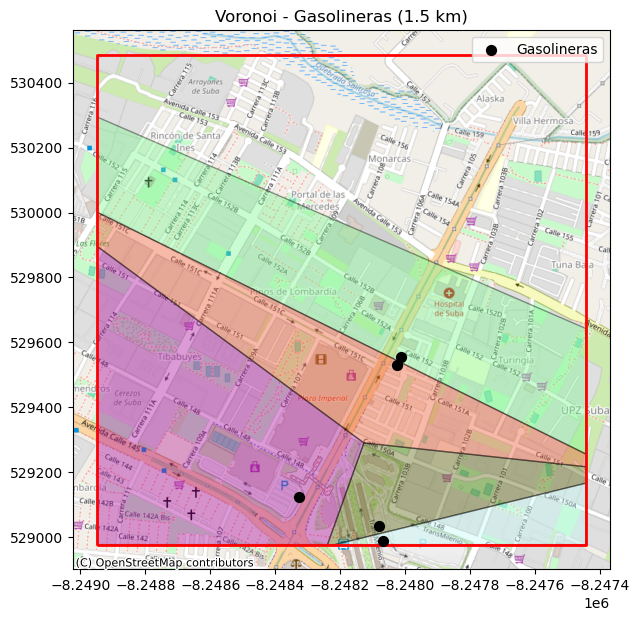

Mapa Voronoi de Gasolineras guardado en voronoi_outputs\voronoi_gasolineras.png
Exportados GeoJSON/CSV para Gasolineras


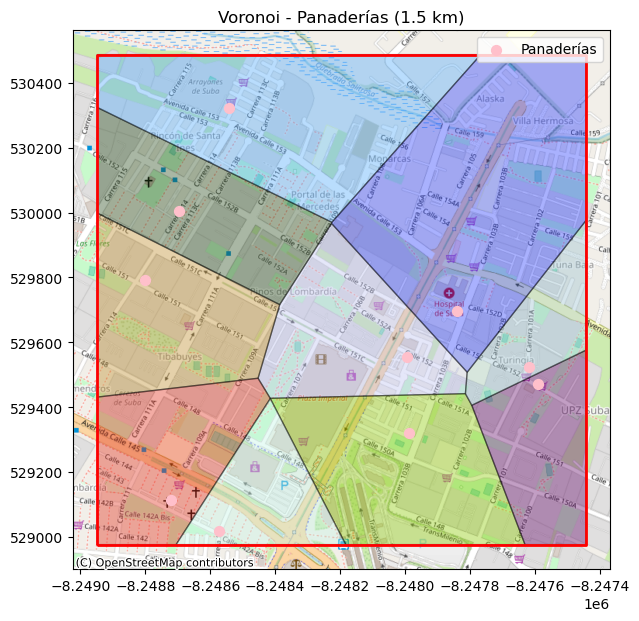

Mapa Voronoi de Panaderías guardado en voronoi_outputs\voronoi_panaderias.png
Exportados GeoJSON/CSV para Panaderías


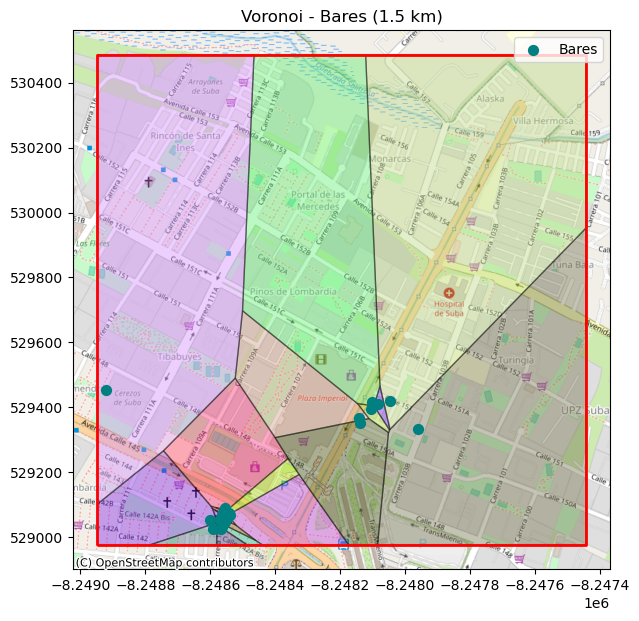

Mapa Voronoi de Bares guardado en voronoi_outputs\voronoi_bares.png
Exportados GeoJSON/CSV para Bares


In [14]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box, Polygon, Point, LineString
from shapely.ops import split
from scipy.spatial import Voronoi
import numpy as np
import requests
import random
import os

# -------------------------
# Funciones auxiliares (igual que antes)
# -------------------------
def get_pois(center_lat, center_lon, size_km, query_filter):
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json][timeout:60];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    try:
        response = requests.get(overpass_url, params={'data': query}, timeout=60)
        response.raise_for_status()
    except Exception as e:
        raise RuntimeError(f"Error llamando Overpass: {e}")

    data = response.json()
    coords = []
    for el in data.get("elements", []):
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    if not coords:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy([c[0] for c in coords], [c[1] for c in coords]),
        crs="EPSG:4326"
    )
    return gdf

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2.0

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if vertices is None:
            continue
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue
            v = v1 if v1 >= 0 else v2
            tangent = vor.points[p2] - vor.points[p1]
            if np.linalg.norm(tangent) == 0:
                continue
            tangent = tangent / np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = vor.vertices[v] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]
        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

# -------------------------
# Fallback corregido para pocos puntos
# -------------------------
def _make_bisector_line(p1, p2, length):
    p1 = np.asarray(p1); p2 = np.asarray(p2)
    mid = (p1 + p2) / 2.0
    v = p2 - p1
    if np.linalg.norm(v) == 0:
        norm = np.array([1.0, 0.0])
    else:
        norm = np.array([-v[1], v[0]])
        norm = norm / np.linalg.norm(norm)
    a = mid + norm * length
    b = mid - norm * length
    return LineString([tuple(a), tuple(b)])

def _voronoi_fallback_by_splitting(points, bbox_polygon):
    """
    Fallback robusto: divide bbox por bisectrices para n=1,2,3.
    Devuelve GeoDataFrame EPSG:3857 con polígonos (filtrando None/Empty).
    """
    n = points.shape[0]
    if n == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")
    if n == 1:
        return gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:3857")

    polys = []
    minx, miny, maxx, maxy = bbox_polygon.bounds
    diag = ((maxx - minx)**2 + (maxy - miny)**2)**0.5
    L = diag * 3.0

    for i in range(n):
        poly = bbox_polygon
        pi = points[i]
        p_pt = Point(pi[0], pi[1])
        for j in range(n):
            if i == j:
                continue
            pj = points[j]
            bis_line = _make_bisector_line(pi, pj, L)
            # split puede devolver GeometryCollection, MultiPolygon, etc.
            try:
                pieces_raw = split(poly, bis_line)
            except Exception:
                # si split falla por alguna razón geométrica, intentamos continuar
                continue

            # normalizar piezas a lista de polígonos útiles
            pieces = []
            try:
                # pieces_raw es iterable; convertir a lista y filtrar sólo polígonos
                for g in list(pieces_raw):
                    if g.geom_type in ("Polygon", "MultiPolygon"):
                        pieces.append(g)
            except TypeError:
                # si no es iterable, omitir
                pieces = []

            if not pieces:
                # no hubo corte en polígonos; continuar con siguiente bisectriz
                continue
            if len(pieces) == 1:
                # sólo una pieza poligonal -> no se dividió realmente
                continue

            # Elegir la pieza que corresponde al punto pi
            chosen = None
            for piece in pieces:
                # preferir 'covers' o 'contains' (más robusto si punto en frontera)
                if piece.covers(p_pt) or piece.contains(p_pt):
                    chosen = piece
                    break
            if chosen is None:
                # si ninguno cubre, elegir la pieza con mínima distancia entre punto y centroid
                centroids = [piece.representative_point() for piece in pieces]
                dists = [p_pt.distance(c) for c in centroids]
                idx = int(np.argmin(dists))
                chosen = pieces[idx]

            poly = chosen
            if poly.is_empty:
                break

        if (poly is None) or poly.is_empty:
            polys.append(None)
        else:
            polys.append(poly)

    # filtrar nulos y crear GeoDataFrame
    valid_polys = [p for p in polys if (p is not None and not p.is_empty)]
    gdf = gpd.GeoDataFrame({"geometry": valid_polys}, crs="EPSG:3857")
    gdf = gdf.reset_index(drop=True)
    return gdf

# -------------------------
# Función principal (igual a la tuya, usando el fallback corregido)
# -------------------------
def compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             category_name, query_filter, color, filename,
                             zoom=16, save_geojson=False, out_folder="."):
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg; lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg; lon_max = center_lon + delta_deg
    if lon_min > lon_max: lon_min, lon_max = lon_max, lon_min
    if lat_min > lat_max: lat_min, lat_max = lat_max, lat_min

    bbox = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
    gdf_bbox_3857 = gdf_bbox.to_crs(epsg=3857)

    try:
        bbox_union = gdf_bbox_3857.geometry.union_all()
    except Exception:
        bbox_union = gdf_bbox_3857.geometry.unary_union

    gdf_pois = get_pois(center_lat, center_lon, size_km, query_filter)
    if gdf_pois.empty:
        print(f"No se encontraron {category_name} en el área.")
        return
    gdf_pois_3857 = gdf_pois.to_crs(epsg=3857)

    points = np.array([[pt.x, pt.y] for pt in gdf_pois_3857.geometry])
    if points.shape[0] < 2:
        print(f"No hay suficientes puntos para Voronoi de {category_name} (se requieren al menos 2).")
        return
    if points.shape[0] < 4:
        print(f"Aviso: solo {points.shape[0]} puntos en {category_name} — usando método fallback cuando sea necesario.")

    gdf_voronoi = None
    if points.shape[0] >= 4:
        try:
            vor = Voronoi(points)
            regions, vertices = voronoi_finite_polygons_2d(vor, radius=None)
            polygons = []
            for region in regions:
                poly = Polygon(vertices[region])
                if poly.is_valid:
                    polygons.append(poly)
            if polygons:
                gdf_voronoi = gpd.GeoDataFrame({"geometry":polygons}, crs="EPSG:3857")
        except Exception as e:
            print(f"Warning: Voronoi clásico falló ({e}), usando fallback geométrico.")
            gdf_voronoi = _voronoi_fallback_by_splitting(points, bbox_union)
    else:
        gdf_voronoi = _voronoi_fallback_by_splitting(points, bbox_union)

    if gdf_voronoi is None or gdf_voronoi.empty:
        print(f"No se pudieron construir polígonos Voronoi para {category_name}.")
        return

    try:
        gdf_voronoi_clipped = gpd.overlay(gdf_voronoi, gdf_bbox_3857, how="intersection")
    except Exception:
        gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(bbox_union)
        gdf_voronoi_clipped = gdf_voronoi[gdf_voronoi.geometry.area > 0].copy()

    if gdf_voronoi_clipped.empty:
        print(f"Tras recorte no hay polígonos Voronoi dentro del bounding box para {category_name}.")
        return

    # Plot y guardado
    fig, ax = plt.subplots(figsize=(7,7))
    gdf_bbox_3857.boundary.plot(ax=ax, color="red", linewidth=2)
    gdf_voronoi_clipped = gdf_voronoi_clipped.reset_index(drop=True)
    rand_colors = [(random.random(), random.random(), random.random()) for _ in range(len(gdf_voronoi_clipped))]
    gdf_voronoi_clipped.plot(ax=ax, facecolor=rand_colors, edgecolor="black", alpha=0.4)
    gdf_pois_3857.plot(ax=ax, color=color, markersize=50, label=category_name, zorder=5)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()

    os.makedirs(out_folder, exist_ok=True)
    out_png = os.path.join(out_folder, filename)
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.title(f"Voronoi - {category_name} ({size_km} km)")
    plt.show()
    print(f"Mapa Voronoi de {category_name} guardado en {out_png}")

    if save_geojson:
        gdf_voronoi_clipped.to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_voronoi.geojson"), driver="GeoJSON")
        gdf_pois_3857.to_crs(epsg=4326).to_file(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.geojson"), driver="GeoJSON")
        pois_4326 = gdf_pois_3857.to_crs(epsg=4326)
        pois_4326['lon'] = pois_4326.geometry.x; pois_4326['lat'] = pois_4326.geometry.y
        pois_4326[['lat','lon']].to_csv(os.path.join(out_folder, f"{category_name.replace(' ','_').lower()}_pois.csv"), index=False)
        print(f"Exportados GeoJSON/CSV para {category_name}")

# -------------------------
# Ejecutar para las categorías
# -------------------------
CATEGORIES = [
    ("Droguerías", '["amenity"="pharmacy"]', "blue", "voronoi_droguerias.png"),
    ("Centros de salud (ampliado)", '["amenity"~"hospital|clinic|doctors"]', "red", "voronoi_salud_ampliado.png"),
    ("Supermercados", '["shop"="supermarket"]', "green", "voronoi_supermercados.png"),
    ("Colegios", '["amenity"="school"]', "orange", "voronoi_colegios.png"),
    ("Restaurantes", '["amenity"="restaurant"]', "purple", "voronoi_restaurantes.png"),
    ("Cafés", '["amenity"="cafe"]', "brown", "voronoi_cafes.png"),
    ("Bancos", '["amenity"="bank"]', "gray", "voronoi_bancos.png"),
    ("Gasolineras", '["amenity"="fuel"]', "black", "voronoi_gasolineras.png"),
    ("Panaderías", '["shop"="bakery"]', "pink", "voronoi_panaderias.png"),
    ("Bares", '["amenity"="bar"]', "teal", "voronoi_bares.png"),
]

center_lat, center_lon = 4.7532, -74.0948
size_km = 1.5
zoom = 16
output_folder = "voronoi_outputs"

for name, qfilter, color, fname in CATEGORIES:
    compute_and_plot_voronoi(center_lat, center_lon, size_km,
                             name, qfilter, color, fname,
                             zoom=zoom, save_geojson=True, out_folder=output_folder)


Definimos un bounding box (≈ 1 km × 1 km) centrado en el punto del enlace de Google Maps: center = (4.7553706, -74.0948258).

la idea es marcar droguerias y supermercados en mi area y saber la distribucion 

Consultamos OpenStreetMap vía Overpass para obtener, dentro de ese bounding box, los POI por categoría:

amenity=pharmacy (droguerías), amenity=hospital (centros de salud), shop=supermarket (supermercados) y  amenity=school (colegios)

Construimos el diagrama de Voronoi con scipy.spatial.Voronoi sobre los puntos (en coordenadas métricas).

Recortamos (clip) las celdas de Voronoi con el bounding box para evitar celdas infinitas o que salgan del área  que nos interesa en este caso utilice un area comercial de interes cerca de mi casa, en la localidad de suba

Graficamos cada Voronoi (una figura por categoría) sobre el mapa base de OpenStreetMap y guardamos PNGs.

1. Supuestos, transformaciones y decisiones metodológicas

El Bounding box fue construido como un cuadrado de ~1 km por lado usando la aproximación 1 km ≈ 0.009° en lat/long. Esto es aceptable para generar el área; sin embargo la equivalencia grados ↔ metros cambia con la latitud (más crítica en longitudes).

Para el recorte de Voronoi, las regiones de Voronoi son, por definición, potencialmente infinitas. scipy.spatial.Voronoi requiere al menos 4 puntos no colineales. 

Entonces Implemente una verificación y no genere Voronoi si hay menos puntos.


1. Limitaciones y fuentes de error / sesgo

Cobertura e integridad de OSM: Overpass devuelve lo que hay en OpenStreetMap. En algunas zonas los POI o púntos de interes están incompletos o mal etiquetados → resultados pueden subestimar el número real de establecimientos. por ejemplo este metodo ignora unas cuantas tiendas que conozco en ese sector, aunque con hospitales y escuelas es mucho mejor los locales mas independientes si son un problema para etiquetarlo y tambien pueden estar variando en el tiempo mucho mas facilmente.

Sensibilidad al número y distribución de puntos: Voronoi depende completamente de la posición de los POI; si hay muy pocos puntos o están muy agrupados, las celdas resultan poco informativas (celdas muy grandes o muy pequeñas).

2. Interpretación práctica de los Voronoi resultantes

Cada celda recortada muestra la porción del área dentro del bounding box que está más cercana a su POI generador que a cualquier otro POI de la misma categoría (distancia euclidiana en EPSG:3857).

Usos prácticos: Visualizar zona de influencia teórica de cada establecimiento (útil para análisis de cobertura o identificación de vacíos de servicio), tambien me parece una estrategia util de distribucion. Me recuerda un poco a la ley de Hotelling en algunos casos

Identificar áreas mal servidas: celdas muy grandes indican baja densidad de oferta dentro del área.

Comparar densidad relativa entre categorías (p. ej. más colecios que farmacias en la muestra).

No representar distancias reales basadas en red (calles). Voronoi usa distancia en línea recta; para accesibilidad peatonal/vehicular se requiere análisis de red (p. ej. isócronas con OSMnx/NetworkX).
